In [369]:
import arcpy
import arcgis
from arcgis.gis import GIS
from arcgis.mapping import WebMap
from arcgis.features import FeatureLayerCollection
from arcgis.geometry import Geometr
import pandas as pd
import os
import re
import zipfile
import shutil

In [352]:
# Instantiate main gis object with ArcGIS API for python
gis = GIS("https://reachinitiative.maps.arcgis.com", "reach_libya", "Reach2019")

In [353]:
# Read and prep data
# Read
file = r"C:\Users\jneuj\Dropbox\2. research projects\4. Development\1. ABA\2. ABA Sebha 2019\4. Tools\Tools Draft\Service areas\REACH_LBY_ABA_MFGD_Service Areas_v1_JNE_test.xlsx"
sheet = "Electricity KII"
quest = pd.read_excel(file, sheet_name = sheet)

# Filter first rows of generic data out
quest = quest[quest['Sub-research question '].notnull() & quest['Geometry'].notnull()]


In [354]:
quest.head()

,Research Question,Sub-research question,Question #,Indicator/variable,Category,Question,Probes,Facilitator Instructions/Training,Geometry,Attributes,Comments Joost
10,1. Where are the city's neighbourhoods and wha...,1.1. What key infrastructure exists in eac...,11,NaN,Service provider,Where are the GECOL offices in Sebha?,Which is the main office? Does each office hav...,"Draw a point on the map for each office, fill ...",Point,"Function, amount_employed, operational",NaN
11,1. Where are the city's neighbourhoods and wha...,1.1. What key infrastructure exists in eac...,12,NaN,Service area,Can you indicate how the electricity grid in S...,Are their maps available showing the electric...,Use the paper map showing the street light net...,Polyline,"Voltage, operational",1. Prepare paper map of electricity grid ...
12,1. Where are the city's neighbourhoods and wha...,1.1. What key infrastructure exists in eac...,13,NaN,Service area,Is the voltage and ampere the same in every ar...,NaN,"If applicable, draw zones on the map where the...",Polygon,"Power, voltage, ampere",NaN
13,1. Where are the city's neighbourhoods and wha...,1.1. What key infrastructure exists in eac...,14,NaN,Service area,Where does the electricity supply for Sebha co...,NaN,"If applicable, draw the high voltage supply li...",Polyline,Source,Draw a line from the site(s) of electricity pr...
14,1. Where are the city's neighbourhoods and wha...,1.1. What key infrastructure exists in eac...,15,NaN,Service area,How has the electricity grid developed over th...,Are their maps available demonstrating the dev...,We would like to know how the electricity grid...,Polygon,year,"1. During training, show how it is okay to dra..."


In [355]:
# Create empty file geodatabase for each FGD/KI
fgdb_loc = r"C:\Users\jneuj\Dropbox\6. GIS\GeoData\ABA Sebha"
arcpy.CreateFileGDB_management(fgdb_loc, sheet)

<Result 'C:\\Users\\jneuj\\Dropbox\\6. GIS\\GeoData\\ABA Sebha\\Electricity KII.gdb'>

In [356]:
# Create featureclasses for each question in KI/FGD
for q in quest.Question:
    numq = quest.loc[quest['Question'] == q, 'Question #'].iloc[0]
    out_path = os.path.join(fgdb_loc, sheet + ".gdb")
    out_name = "q" + str(numq)
    alias = q
    geometry_type = quest.loc[quest['Question'] == q, 'Geometry'].iloc[0]
    sr = arcpy.SpatialReference(3857)
    
    # Create feature class for each question
    arcpy.CreateFeatureclass_management(out_path, out_name, geometry_type, spatial_reference = sr )
    print(out_name)
    
   

q11
q12
q13
q14
q15
q16
q17
q18
q19
q20
q21
q22
q23
q24
q25
q27
q28
q29


In [357]:
# Create some domains on the geodatabase
# positionGround: above or below the ground
domName = "positionGround"
arcpy.CreateDomain_management(out_path, domName, field_type = "TEXT", domain_type = "CODED")
dictPositionGround = {"Above":"Above", "Below": "Below", "Other": "Other"}
for code in dictPositionGround:
    arcpy.AddCodedValueToDomain_management(out_path, domName, code, dictPositionGround[code])
    
# operational: is something fully, partially, not operational, other
domName = "operational"
arcpy.CreateDomain_management(out_path, domName, field_type = "TEXT", domain_type = "CODED")
dictOperational = {"Fully operational": "Fully operational", "Partially operational": "Partially operational", "Not operational": "Not operational", "Other": "Other"}
for code in dictOperational:
    arcpy.AddCodedValueToDomain_management(out_path, domName, code, dictOperational[code])

In [360]:
arcpy.env.workspace = r"Dropbox\6. GIS\GeoData\ABA Sebha\Electricity KII.gdb"
featureClasses = arcpy.ListFeatureClasses()
count = 0

for fc in featureClasses:
    # Get question number in questionnaire
    number = re.findall(r'\d+', str(fc))
    # Get attribute string, containing all attributes for that question
    attrList = quest.loc[quest['Question #'] == int(number[0]), 'Attributes'].iloc[0].split(', ')
    for attr in attrList:
        print(str(fc) + ' ' + str(attr))
        if attr in [f.name for f in arcpy.ListFields(fc)]:
            print('Already exists')
        else: 
            # Add attribute to feature class
            if "perationa" in attr:
                arcpy.AddField_management(fc, attr, "TEXT", field_length = 900, field_is_nullable = "NON_NULLABLE", field_is_required = "REQUIRED", field_domain = "operational")
            elif 'osition' in attr:
                arcpy.AddField_management(fc, attr, "TEXT", field_length = 900, field_is_nullable = "NON_NULLABLE", field_is_required = "REQUIRED", field_domain = "positionGround")
            else:
                arcpy.AddField_management(fc, attr, "TEXT", field_length = 900, field_is_nullable = "NON_NULLABLE", field_is_required = "REQUIRED")
                print('here')
    

q11 Function
Already exists
q11 amount_employed
Already exists
q11 operational
Already exists
q12 Voltage
Already exists
q12 operational
Already exists
q13 Power
Already exists
q13 voltage
Already exists
q13 ampere
Already exists
q14 Source
Already exists
q15 year
Already exists
q16 Position
Already exists
q17 details
Already exists
q17 owner
Already exists
q17 operational
Already exists
q18 details
Already exists
q18 owner
Already exists
q18 operational
Already exists
q19 Reason
Already exists
q20 Reason
Already exists
q21 Reason
Already exists
q21 frequency
Already exists
q22 Reason
Already exists
q23 Consequence
Already exists
q24 Strategy
Already exists
q27 Project
here
q27 partners
here
q27 details
here
q28 Project
here
q28 partners
here
q28 details
here
q29 Partners
here


In [374]:
#When I zip fgdb with code below, the publish to AGOL does not work. Only via the zip tool in arcgis Pro.

#Zip folder file geodatabase for upload to AGOL
#shutil.make_archive(os.path.join(fgdb_loc,sheet+'.gdb'), 'zip', os.path.join(fgdb_loc,sheet+'.gdb') )

'C:\\Users\\jneuj\\Dropbox\\6. GIS\\GeoData\\ABA Sebha\\Electricity KII.gdb.zip'

In [400]:
# It is not possible at the moment to publish a geodatabase to arcgis online.
fgdb = r"C:\Users\jneuj\Dropbox\6. GIS\GeoData\ABA Sebha\Electricity KII.gdb.zip"
serviceProp = {}
serviceProp['type'] = 'File Geodatabase'
serviceProp['itemType'] = "file"
serviceProp['tags'] = "ABA"
serviceProp["layerInfo"] = {"capabilities":"Query,Editing,Create,Update,Delete,Sync,Extract"}

pubProps = {}
pubProps["hasStaticData"] = 'true'
pubProps["name"] = sheet
pubProps["maxRecordCount"] = 2000
pubProps["layerInfo"] = {"capabilities":"Query,Editing,Create,Update,Delete,Sync,Extract"}
pubProps["supportsDisconnectedEditing"] = True
pubProps["copyrightText"] = "Internal use only. Do not use the data without contacting REACH Libya."
pubProps["initialExtent"] = {
    "xmin": 14.3152663,
    "ymin": 26.9689241,
    "xmax": 14.5067186,
    "ymax": 27.0980750,
    "spatialReference": {
      "wkid": 102100,
      "latestWkid": 3857
    }
  }
pubProps["syncEnabled"] = True
pubProps["allowOthersToDelete"] = True
pubProps["allowOthersToQuery"] = True
pubProps["allowOthersToEdit"] = True
pubProps["allowAnonymousToQuery"] = False
pubProps["allowAnonymousToEdit"] = False
pubProps["allowAnonymousToDelete"] = False

fgdb1 = gis.content.add(item_properties=serviceProp, data = fgdb, folder = "PM ABA Sebha")
fgdb2 = fgdb1.publish(publish_parameters = pubProps, file_type = 'filegeodatabase', overwrite=True)

In [401]:
# Parts of code below (capabilities) could be added into previous block

search_result = gis.content.search("title:" + sheet + " AND owner:reach_libya", item_type = "Feature Layer", outside_org = False)
#search_result.properties
#found = search_result[0]
test = FeatureLayerCollection.fromitem(search_result[0])
test.properties

{
  "currentVersion": 10.7,
  "serviceItemId": "a3c7912ca6fb4e97b70149f2435590ed",
  "serviceDescription": "",
  "hasVersionedData": false,
  "supportsDisconnectedEditing": false,
  "hasStaticData": true,
  "hasSharedDomains": false,
  "maxRecordCount": 2000,
  "supportedQueryFormats": "JSON",
  "supportsVCSProjection": false,
  "capabilities": "Query,Extract,Sync",
  "description": "",
  "copyrightText": "Internal use only. Do not use the data without contacting REACH Libya.",
  "spatialReference": {
    "wkid": 102100,
    "latestWkid": 3857
  },
  "initialExtent": null,
  "fullExtent": null,
  "allowGeometryUpdates": true,
  "units": "esriMeters",
  "supportsAppend": true,
  "supportsSharedDomains": true,
  "syncEnabled": true,
  "syncCapabilities": {
    "supportsAsync": true,
    "supportsRegisteringExistingData": true,
    "supportsSyncDirectionControl": true,
    "supportsPerLayerSync": true,
    "supportsPerReplicaSync": true,
    "supportsSyncModelNone": true,
    "supportsRol

In [402]:
# Create webmap from Feature Service
# Search for basemap
satView = gis.content.search('title:World Imagery (Clarity), owner:esri', 
                                    outside_org=True, item_type='web map')[0]
# Create empty webmap with basemap
wm = WebMap(satView) 

# Search for correct Feature Service
search_result = gis.content.search("title:" + sheet + " AND owner:reach_libya", item_type = "Feature Layer", outside_org = False)
found = search_result[0]

for lyr in found.layers:
    wm.add_layer(lyr)


###################################################################################   
# Later: adjust visualisation and opacity? offline areas and sync etc. order layers
###################################################################################

# Instantiate properties dictionnary and save the new webmap to AGOL
props = {}
props["type"] = "Web Map"
props["typeKeywords"] = ["ArcGIS Online", "Collector", "Data Editing", "Explorer Web Map", "Map", "Offline", "Online Map", "Web Map"]
props["description"] = "First test to automate webmap generation for ArcGIS Collector"
props["title"] = 'Electricity KII Collector'
props["snippet"] = 'Webmap used for participatory mapping.'
props["tags"] = ["Collector", "ABA", "Sebha", "Offline", "Web Map"]
props["licenseInfo"] = "Internal use only. Do not use the data without contacting REACH Libya."
props["access"] = "org"
props["extent"] = 14.3152663, 26.9689241, 14.5067186, 27.0980750

wm.save(props, owner = "reach_libya", folder = "PM ABA Sebha")

<Item title:"Electricity KII Collector" type:Web Map owner:reach_libya>

<Item title:"Electricity KII Collector" type:Web Map owner:reach_libya>
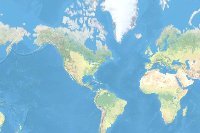

In [404]:
search_result = gis.content.search("title:" + sheet + " AND owner:reach_libya", item_type = "Web Map", outside_org = False)
found = search_result[0]
found

In [433]:
# Create offline area for webmap
# This is also still not working propperly

# Search web map and store as offline object
search_result = gis.content.search("title:" + sheet + " AND owner:reach_libya", item_type = "Web Map", outside_org = False)
wm = WebMap(search_result[0])

# Setting some meta properties
offline_item_properties = {'title': 'Offline area ABA',
                          'tags': ['ABA', 'Sebha', 'REACH'],
                          'snippet': 'Area created for first test'}

# Create area geometry to take offline
geom = Geometry({
  "rings" : [[[27.077451, 14.395788],[27.077451, 14.456441],[27.031410, 14.456441],[27.031410, 14.395788],
              [27.077451, 14.395788]]], "spatialReference" : {"wkid" : 4326}})

from arcgis import env
env.verbose = True

wm_offline = wm.offline_areas.create(area = geom, item_properties = offline_item_properties, min_scale = 500000, max_scale = 50000)


{"code": 24, "messageCode": "OffPkg_ 24", "message": "Parameter extent is invalid or exceeded limit.", "params": {"name": "extent"}}
Failed to execute (CreateMapArea).
Failed.


Submitted.
Executing...
Start Time: Thursday, February 6, 2020 3:35:21 PM
Running script CreateMapArea...
{"code": 24, "messageCode": "OffPkg_ 24", "message": "Parameter extent is invalid or exceeded limit.", "params": {"name": "extent"}}
Completed script CreateMapArea...
Failed to execute (CreateMapArea).
Failed at Thursday, February 6, 2020 3:35:26 PM (Elapsed Time: 5.12 seconds)
Failed.


Exception: Job failed.

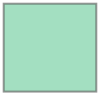

In [427]:

geom = Geometry({
  "rings" : [[[27.077451, 14.375788],[27.077451, 14.476441],[26.971410, 14.476441],[26.971410, 14.375788],
              [27.077451, 14.375788]]], "spatialReference" : {"wkid" : 4326}})
geom

<Item title:"World Imagery" type:Map Image Layer owner:esri>
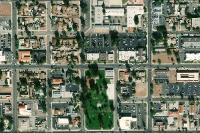

In [443]:
satView = gis.content.search('title:World Satellite imag, owner:esri', 
                                    outside_org=True)[1]
satView

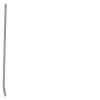

In [415]:
geom